In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from tqdm import tqdm
import os

In [3]:
from weight_datasets import PretrainedWeights, AdditiveNoise, SignFlip

In [4]:
weights_dataset = PretrainedWeights('datasets/PretrainedWeights/', transform=None)
weights_loader = torch.utils.data.DataLoader(weights_dataset, batch_size=5, shuffle=True)

/home/chendi/miniconda3/envs/fedgnn/lib/python3.8/site-packages/torch_geometric/data/dataset.py:190: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to delete 'datasets/PretrainedWeights/processed' first
  warnings.warn(


In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
mnist = MNIST('./datasets', train=False, download=True, transform=transform)

valset = torch.utils.data.Subset(mnist, np.random.randint(0, len(mnist), 2000))
mnistloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=True)

In [6]:
from mnist_cnn import MNIST_CNN

mnist_cnn = MNIST_CNN().to('cuda:0')
mnist_cnn.eval()

MNIST_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [7]:
epochs = 1

In [8]:
from train_val import mnist_validation
from fl_utils import fed_avg, fed_avg_weight_lost, package_loss

In [9]:
accs = {}

In [10]:
lost_keys = [['conv1.weight'], 
             ['conv1.bias'], 
             ['conv2.weight'], 
             ['conv2.bias'], 
             ['fc1.weight'], 
             ['fc1.bias'], 
             ['fc2.weight'], 
             ['fc2.bias'], 
             None]

In [11]:
for key2blost in lost_keys:
    dict_key = key2blost[0] if key2blost is not None else None
    accs[dict_key] = {'no_lost': [],
                       'lost+part_aggr': [],
                       'lost+normal_aggr': []}
    
    for epoch in range(epochs):
        pbar = tqdm(weights_loader)
        pbar.set_description(f'{key2blost} key lost, {epoch}th epoch')
        for weights, labels in pbar:
            weights = {k: w.cuda() for k, w in weights.items()}
            new_w = package_loss(weights, key2blost, ratio_lost=0.5, seed=None)

            w1 = fed_avg(weights)
            w2 = fed_avg_weight_lost(new_w)
            w3 = fed_avg(new_w)
            mnist_cnn.load_state_dict(w1)
            acc1 = mnist_validation(mnistloader, mnist_cnn)
            accs[dict_key]['no_lost'].append(acc1)

            mnist_cnn.load_state_dict(w2)
            acc2 = mnist_validation(mnistloader, mnist_cnn)
            accs[dict_key]['lost+part_aggr'].append(acc2)

            mnist_cnn.load_state_dict(w3)
            acc3 = mnist_validation(mnistloader, mnist_cnn)
            accs[dict_key]['lost+normal_aggr'].append(acc3)

            pbar.set_postfix({'no loss': acc1, 'loss + partaggr': acc2, 'loss + aggr': acc3})

None key lost, 0th epoch: 100%|█████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s, no loss=0.957, loss + partaggr=0.952, loss + aggr=0.894]


In [12]:
import pandas as pd

In [13]:
data_dict = {'category': [], 'acc_good': [], 'acc_lost_partaggr': [], 'acc_lost_fullaggr': []}

In [14]:
for k, v in accs.items():
    lens = len(v['no_lost'])
    data_dict['category'] += [k] * lens
    data_dict['acc_good'] += v['no_lost']
    data_dict['acc_lost_partaggr'] += v['lost+part_aggr']
    data_dict['acc_lost_fullaggr'] += v['lost+normal_aggr']

In [15]:
data = pd.DataFrame.from_dict(data_dict)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

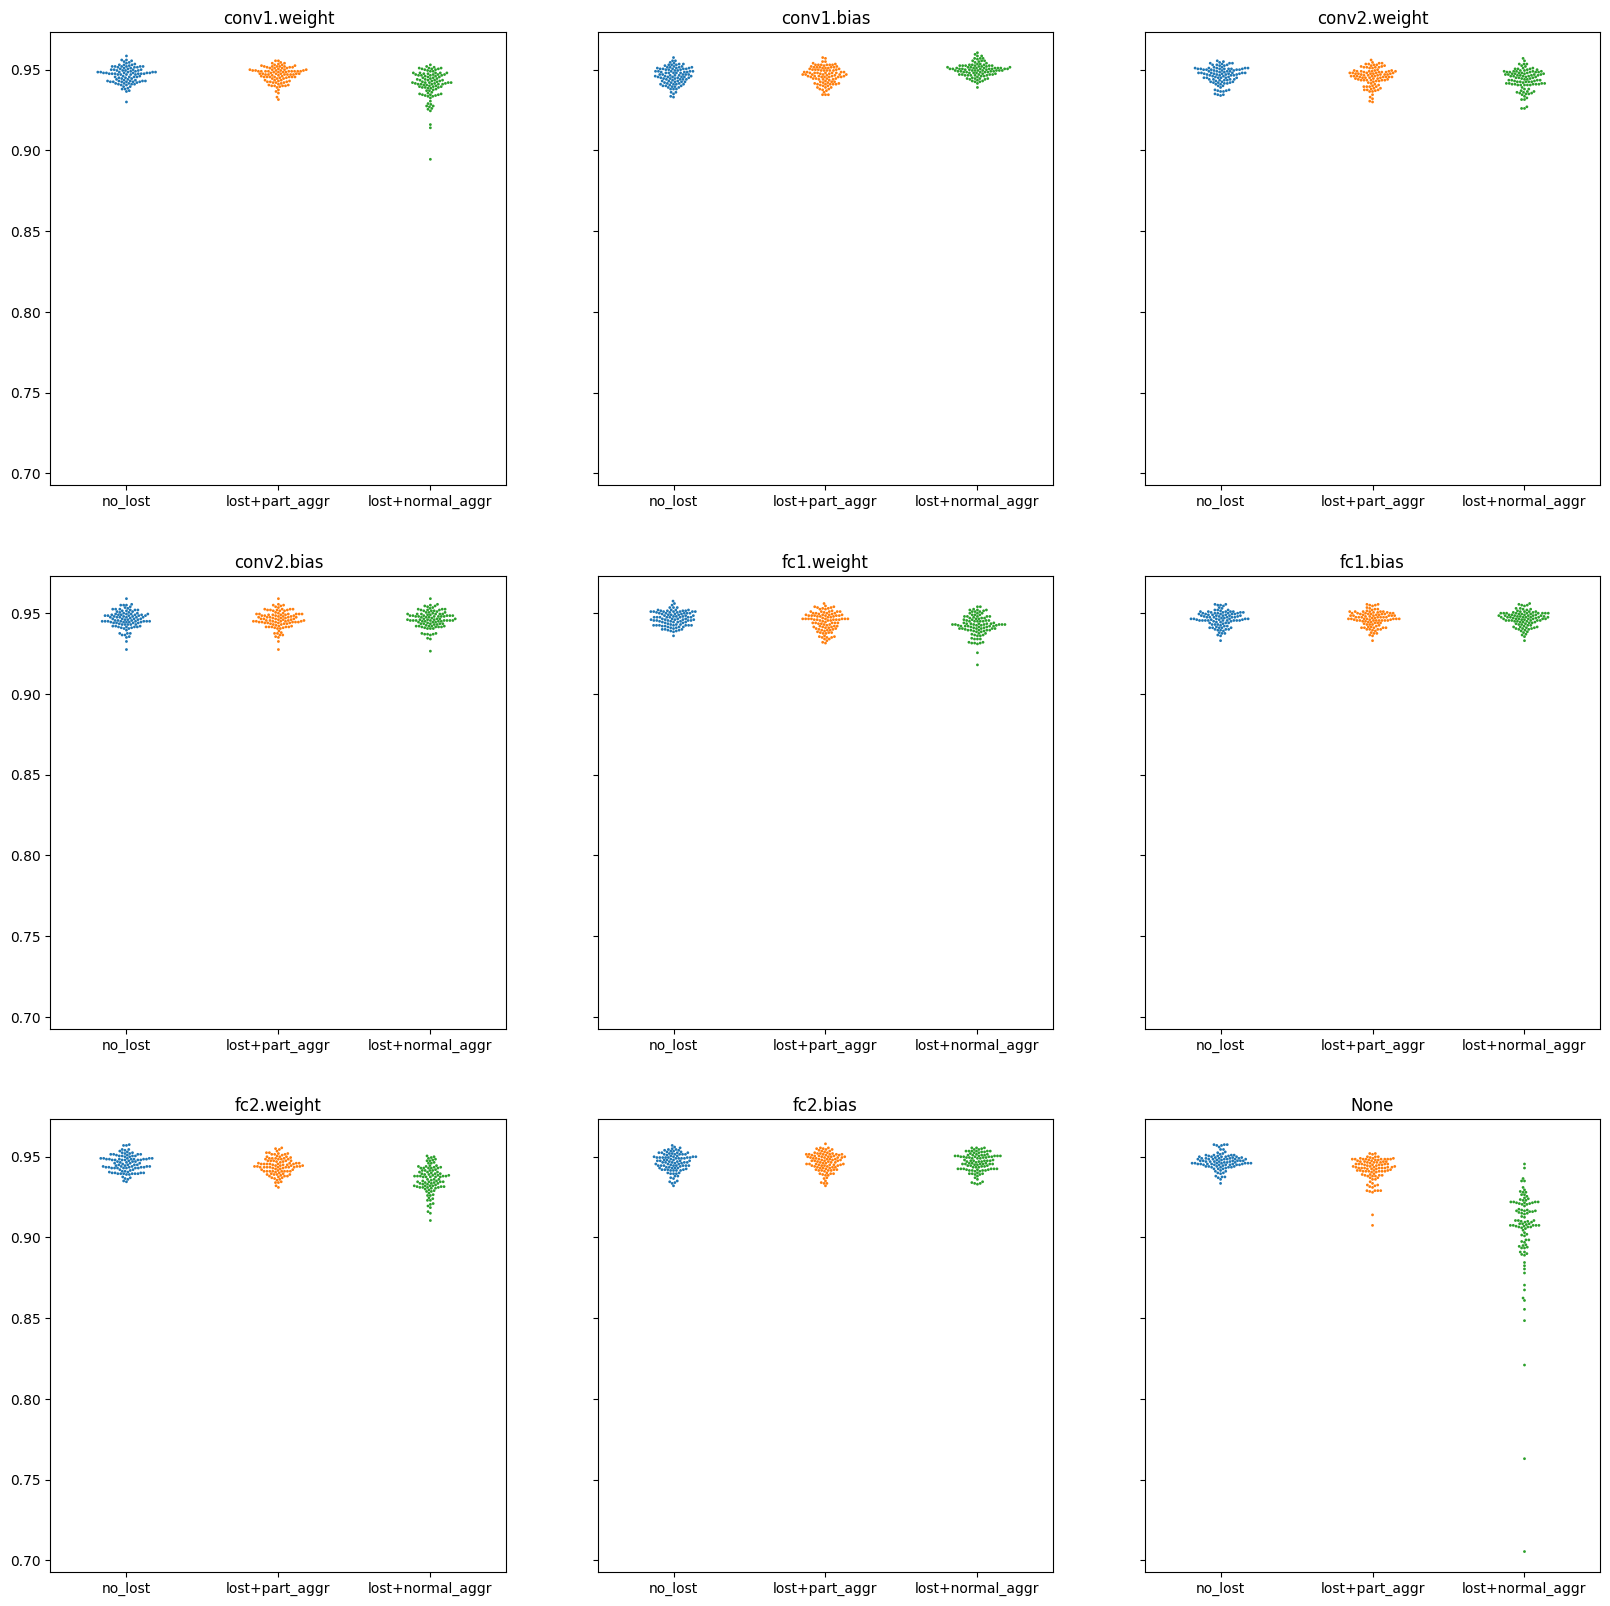

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharey=True)

for i, k in enumerate(lost_keys):
    if isinstance(k, list):
        k = k[0]
    
    data = pd.DataFrame.from_dict(accs[k])
    sns.swarmplot(data, ax=axes[i // 3][i % 3], size=2)
    # sns.violinplot(data, ax=axes[][i], size=2)
    axes[i // 3][i % 3].set_title(str(k))

plt.savefig('pkg_drop.png', dpi=500)